In [1]:
import os
import re
import dotenv
import numpy as np
import pandas as pd
from pprint import pprint

# sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE

# utils
from stop_words import get_stop_words
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import seaborn as sns
from wordcloud import WordCloud

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pyLDAvis

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

2023-10-14 10:22:09.903562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:22:10.679974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-14 10:22:10.680176: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-1

In [2]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [5]:
# read input and agg daily measurements to first()
df = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/interim/data_message_texts_ready_to_topic_modelling.csv', encoding='UTF-8')
df = df.drop_duplicates('text_clean_and_translated')

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4107 entries, 0 to 4216
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         4107 non-null   object 
 1   Message Text               4107 non-null   object 
 2   Date                       4107 non-null   object 
 3   Impressions                4107 non-null   float64
 4   Comments                   4107 non-null   float64
 5   Likes                      4107 non-null   float64
 6   Shares                     4107 non-null   float64
 7   Other Engagements          4107 non-null   float64
 8   Engagements                4107 non-null   float64
 9   days_since_posted          4107 non-null   float64
 10  fanpage_id                 4107 non-null   float64
 11  has_any_image              4107 non-null   bool   
 12  hashtags                   3281 non-null   object 
 13  has_any_hashtag            4107 non-null   bool   
 1

In [7]:
# CONSTANTS
en_stop = get_stop_words('en')
en_stop.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
en_stop.extend(['aftermarket', 'aren', 'bank', 'barmer', 'bosch', 'brasil', 'can', 'ceconomy', 'couldn', 'covestro', 'deutsche', 'dhl', 'didn', 'doesn', 'don', 'dpdhl', 'global', 'group', 'hadn', 'hagglunds', 'hartmann', 'hasn', 'haspa', 'haven', 'henkel', 'isn', 'korber', 'krones', 'let', 'markt', 'media', 'mediamarkt', 'mediamarktsaturn', 'mustn', 'nagra', 'post', 'rexroth', 'saturn', 'schaeffler', 'shan', 'shouldn', 'sonova', 'sparkasse', 'symrise', 'vdi', 'verein', 'wacker', 'wasn', 'weren', 'won', 'wouldn'])
en_stop.extend(os.getenv('COMPANIES').lower().split())

In [8]:
# FUNCTIONS
clean_up_text = lambda text: simple_preprocess( str(text), max_len=100_000, deacc=True )


def lemmatize_text(text, allowed_tags, vocab):
    """https://spacy.io/api/annotation"""
    doc = vocab(" ".join(text))
    return " ".join([token.lemma_ for token in doc if token.pos_ in allowed_tags])

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
# handle later

def compute_c_v_coherence(lda_model, corpus, texts):
    """
    Compute the c_v coherence score for an LDA topic model.
    """
    c_v_coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='c_v')
    return c_v_coherence_model.get_coherence()

def compute_u_mass_coherence(lda_model, corpus, texts):
    """
    Compute the u_mass coherence score for an LDA topic model.
    """
    u_mass_coherence_model = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='u_mass')
    return u_mass_coherence_model.get_coherence()



# plotting

def format_topics_sentences(ldamodel, vectorizer, texts):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get the document-topic distribution from the LDA model
    doc_topic_dists = ldamodel.transform(vectorizer.transform(texts))

    for i, row in enumerate(doc_topic_dists):
        dominant_topic = row.argmax()
        prop_topic = row.max()
        topic_keywords = ",".join([vectorizer.get_feature_names_out()[i] for i in ldamodel.components_[dominant_topic].argsort()[:-5 - 1:-1]])

        new_row = pd.Series([dominant_topic, round(prop_topic, 4), topic_keywords],
                            index=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
        sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)

    # Combine the results with the original text
    sent_topics_df = pd.concat([sent_topics_df, pd.Series(texts, name='Text')], axis=1)

    return sent_topics_df

In [9]:
# Convert to list
data = df.text_clean_and_translated.values.tolist()
#weights = df.class_weight.values.tolist()
post_ids = df.ID.values.tolist()

In [10]:
# removing punctuations and unnecessary characters
# no max len for a token
# deacc=True removes punctuations
data_words = list(map(clean_up_text, data))
print(data_words[:1])

[['we', 'wish', 'you', 'all', 'happy', 'and', 'healthy', 'tackle', 'your', 'wishes', 'and', 'dreams', 'so', 'that', 'they', 'become', 'reality']]


In [12]:
!python -m spacy download en_core_web_sm

2023-10-14 10:23:52.984002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 10:23:53.805998: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-14 10:23:53.806082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-1

In [13]:
spacy.load('en_core_web_sm')

In [14]:
# Do lemmatization keeping only noun, adj, vb, adv
import functools
data_lemmatized = list(map(
    functools.partial(
        lemmatize_text, 
        vocab=spacy.load('en_core_web_sm', disable=['parser', 'ner']),
        allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']
    ),
    data_words
))

print(data_lemmatized[:1])

['wish happy healthy tackle wish dream become reality']


In [15]:
vec_ct = CountVectorizer(analyzer='word',
                             min_df=0.1,
                             strip_accents = 'unicode',
                             stop_words=en_stop,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

vec_tfidf = TfidfVectorizer(analyzer='word',
                             min_df=15,
                             stop_words=en_stop,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

X_ct = vec_ct.fit_transform(data_lemmatized)
X_tfidf = vec_tfidf.fit_transform(data_lemmatized)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gglunds', 'rber'] not in stop_words.
  warnings.warn(


In [ ]:
# Create custom scorers
c_v_scorer = make_scorer(compute_c_v_coherence, greater_is_better=True)
u_mass_scorer = make_scorer(compute_u_mass_coherence, greater_is_better=True)

# Define your parameter grid for LDA
param_grid = {
    'n_components': [3, 4, 5, 6],
    'learning_offset': [10, 15],
    'learning_decay': [.3, .6, .9]
}

# Create an LDA model
lda_model = LatentDirichletAllocation()
#scoring={'c_v': c_v_scorer, 'u_mass': u_mass_scorer},
# Create a GridSearchCV object with the custom scorers
grid_search_cv = GridSearchCV(lda_model, param_grid, cv=5)

# Fit the grid search
grid_search_cv.fit(X_tfidf)  # Replace 'corpus' with your data

In [40]:
# Best Model
best_lda_model = grid_search_cv.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_cv.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_cv.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_tfidf))

Best Model's Params:  {'learning_decay': 0.3, 'learning_offset': 10, 'n_components': 6}
Best Log Likelihood Score:  -34537.918493333775
Model Perplexity:  2624.012543745606


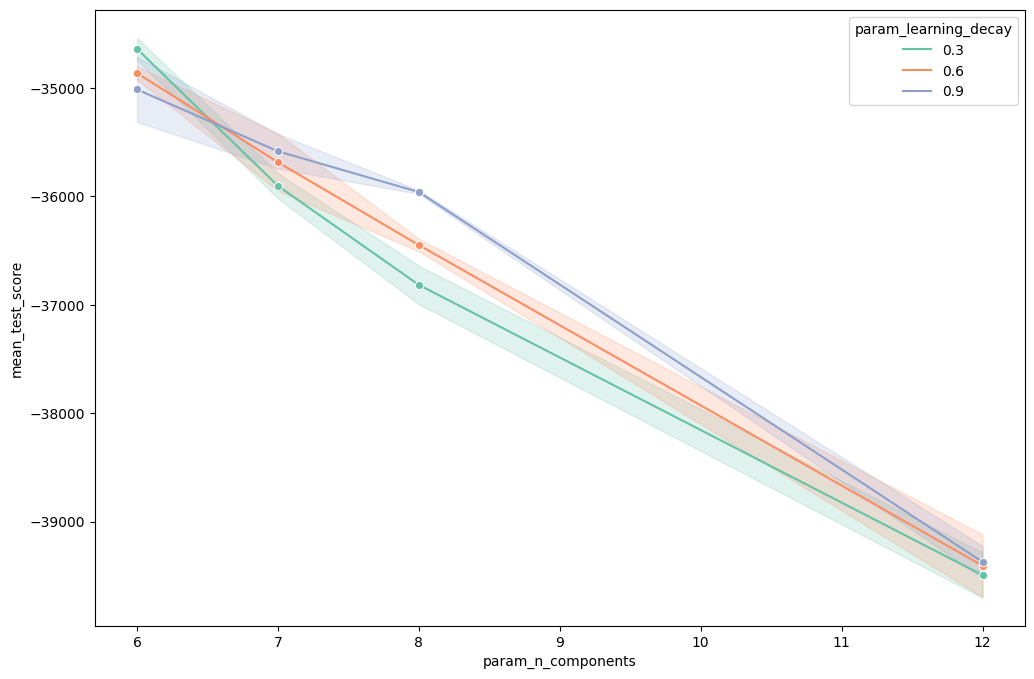

In [58]:
results = pd.DataFrame(grid_search_cv.cv_results_)
current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             # https://github.com/mwaskom/seaborn/issues/1515
             palette=current_palette,
             marker='o'
            )

# # Would need a good way to show three error bars
# plt.errorbar(x=results['param_n_components'],
#              y=results.mean_test_score,
#              yerr=results.std_test_score,
#              fmt='none',
#              color=current_palette[0])

plt.show()

In [42]:
# Values for the above plot
results[['param_learning_decay',
         'param_n_components',
         'mean_test_score']].pivot_table(columns=['param_learning_decay',
                                  'param_n_components'])

param_learning_decay           0.3                                           \
param_n_components              6             7            8             12   
mean_test_score      -34641.307506 -35903.981184 -36816.86168 -39492.321427   

param_learning_decay           0.6                                           \
param_n_components              6            7             8             12   
mean_test_score      -34864.052583 -35686.20603 -36449.713159 -39405.224335   

param_learning_decay           0.9                                            
param_n_components              6             7             8             12  
mean_test_score      -35015.150053 -35584.879693 -35960.917758 -39370.568494

In [43]:
# std for the values in the above plot
results[['param_learning_decay',
         'param_n_components',
         'std_test_score']].pivot_table(columns=['param_learning_decay',
                                  'param_n_components'])

param_learning_decay        0.3                                       \
param_n_components           6           7           8            12   
std_test_score        710.41536  766.091858  588.520053  1353.214507   

param_learning_decay         0.6                                      \
param_n_components            6           7           8           12   
std_test_score        502.519882  855.405045  635.188745  879.770649   

param_learning_decay         0.9                                      
param_n_components            6           7           8           12  
std_test_score        336.837144  715.000794  710.421746  528.420306

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis_data = pyLDAvis.prepare(
    topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis],
    doc_topic_dists = best_lda_model.transform(X_tfidf),
    doc_lengths = X_tfidf.sum(axis=1).A1,
    vocab = vec_tfidf.get_feature_names_out(),
    term_frequency = X_tfidf.sum(axis=0).A1,
)
pyLDAvis.display(pyLDAvis_data)

In [45]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(X_tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.400000,0.050000,0.410000,0.050000,0.050000,0.050000,2
Doc1,0.040000,0.040000,0.250000,0.040000,0.030000,0.610000,5
Doc2,0.230000,0.040000,0.040000,0.040000,0.040000,0.620000,5
Doc3,0.050000,0.050000,0.770000,0.050000,0.050000,0.050000,2
Doc4,0.060000,0.060000,0.690000,0.060000,0.060000,0.060000,2
Doc5,0.030000,0.030000,0.030000,0.700000,0.030000,0.170000,3
Doc6,0.030000,0.030000,0.030000,0.030000,0.030000,0.840000,5
Doc7,0.020000,0.880000,0.020000,0.020000,0.020000,0.020000,1
Doc8,0.630000,0.050000,0.160000,0.050000,0.050000,0.050000,0
Doc9,0.030000,0.030000,0.030000,0.030000,0.030000,0.840000,5


In [46]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,1390
1,1,1242
2,3,882
3,5,360
4,2,139
5,4,94


In [47]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vec_tfidf.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,accelerate,accept,access,accompany,accord,account,accuracy,achieve,...,world,worldwide,worth,wound,write,year,yesterday,yet,young,youth
Topic0,1.736212,10.192272,3.290396,3.184337,4.511366,0.312644,7.437196,4.404681,0.254170,12.538790,...,17.807033,6.647015,3.422180,0.167604,2.347850,36.440025,5.197282,3.058122,0.576304,0.166970
Topic1,1.807249,11.207095,1.290531,0.180084,3.106871,3.722666,0.779895,2.572997,0.167128,7.248410,...,19.975736,3.839400,1.854515,0.167320,2.585048,33.934600,4.259544,1.711822,16.174542,3.727147
Topic2,0.167977,0.166954,0.167691,0.465479,0.166693,0.166694,0.167045,0.166690,0.166690,0.169137,...,1.750946,1.224633,0.166695,0.166673,0.167834,9.280117,0.896878,0.166776,0.166741,0.166672
Topic3,1.752526,1.758105,1.594287,0.167185,4.834528,0.167548,1.965717,0.166846,3.861767,5.265598,...,7.515722,0.601130,0.543153,0.166701,0.172901,3.018899,0.170324,1.852766,0.718569,0.166689
Topic4,0.166688,0.167081,0.166691,0.166714,4.478674,0.166742,0.166814,1.202637,0.166696,0.166692,...,2.244448,0.166709,0.166704,0.166695,0.166701,0.673218,0.166701,0.172988,0.166695,0.166674


In [48]:
topic_keywords = show_topics(vectorizer=vec_tfidf, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,energy,sustainable,year,new,sustainability,future,business,climate,company,technology,solution,product,customer,market,industry
Topic 1,work,team,day,career,year,employee,look,opportunity,event,student,project,support,training,new,together
Topic 2,happy,diversity,wish,day,vote,celebrate,year,inclusion,equity,love,family,gender,woman,celebration,one
Topic 3,system,solution,hydraulic,machine,drive,application,control,automation,production,new,learn,robot,component,efficiency,design
Topic 4,certify,partner,factory,solution,booth,automation,excellence,class,today,quality,win,stop,present,suburb,certification
Topic 5,hashtag,booth,visit,automation,show,silicone,solution,stand,product,expert,register,wound,battery,industry,hall


In [49]:
# Format
df_dominant_topic = format_topics_sentences(best_lda_model, vec_tfidf, data).reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.4086,"energy,sustainable,year,new,sustainability",We wish you all a happy and healthy 2023. Tack...
1,1,5,0.4828,"hashtag,booth,visit,automation,show",happy new year from everyone at bosch and we h...
2,2,5,0.4575,"hashtag,booth,visit,automation,show",are you ready for 2023 we are as we welcome th...
3,3,2,0.7515,"happy,diversity,wish,day,vote",we at krones hope you had a wonderful new year...
4,4,2,0.6879,"happy,diversity,wish,day,vote",happy new year to all of you
5,5,3,0.6219,"system,solution,hydraulic,machine,drive",bosch hashtag rexroth guide the digital future...
6,6,1,0.5259,"work,team,day,career,year","happy new year, dear communitystart the year 2..."
7,7,1,0.8568,"work,team,day,career,year","new year, new... ... professional opportunitie..."
8,8,5,0.4699,"hashtag,booth,visit,automation,show",ready for veganuary we love coming up with new...
9,9,5,0.8159,"hashtag,booth,visit,automation,show",the two steps forward mentality makes ctrlxaut...


In [50]:
df_dominant_topic.loc[:, 'ID'] = post_ids
result = pd.merge(
    df,
    df_dominant_topic.loc[:, ['ID', 'Dominant_Topic', 'Topic_Perc_Contrib']],
    on = 'ID',
    how = 'left'
)

In [60]:
result.to_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/daily_measures_features_full.csv', encoding='utf-8', index=False)

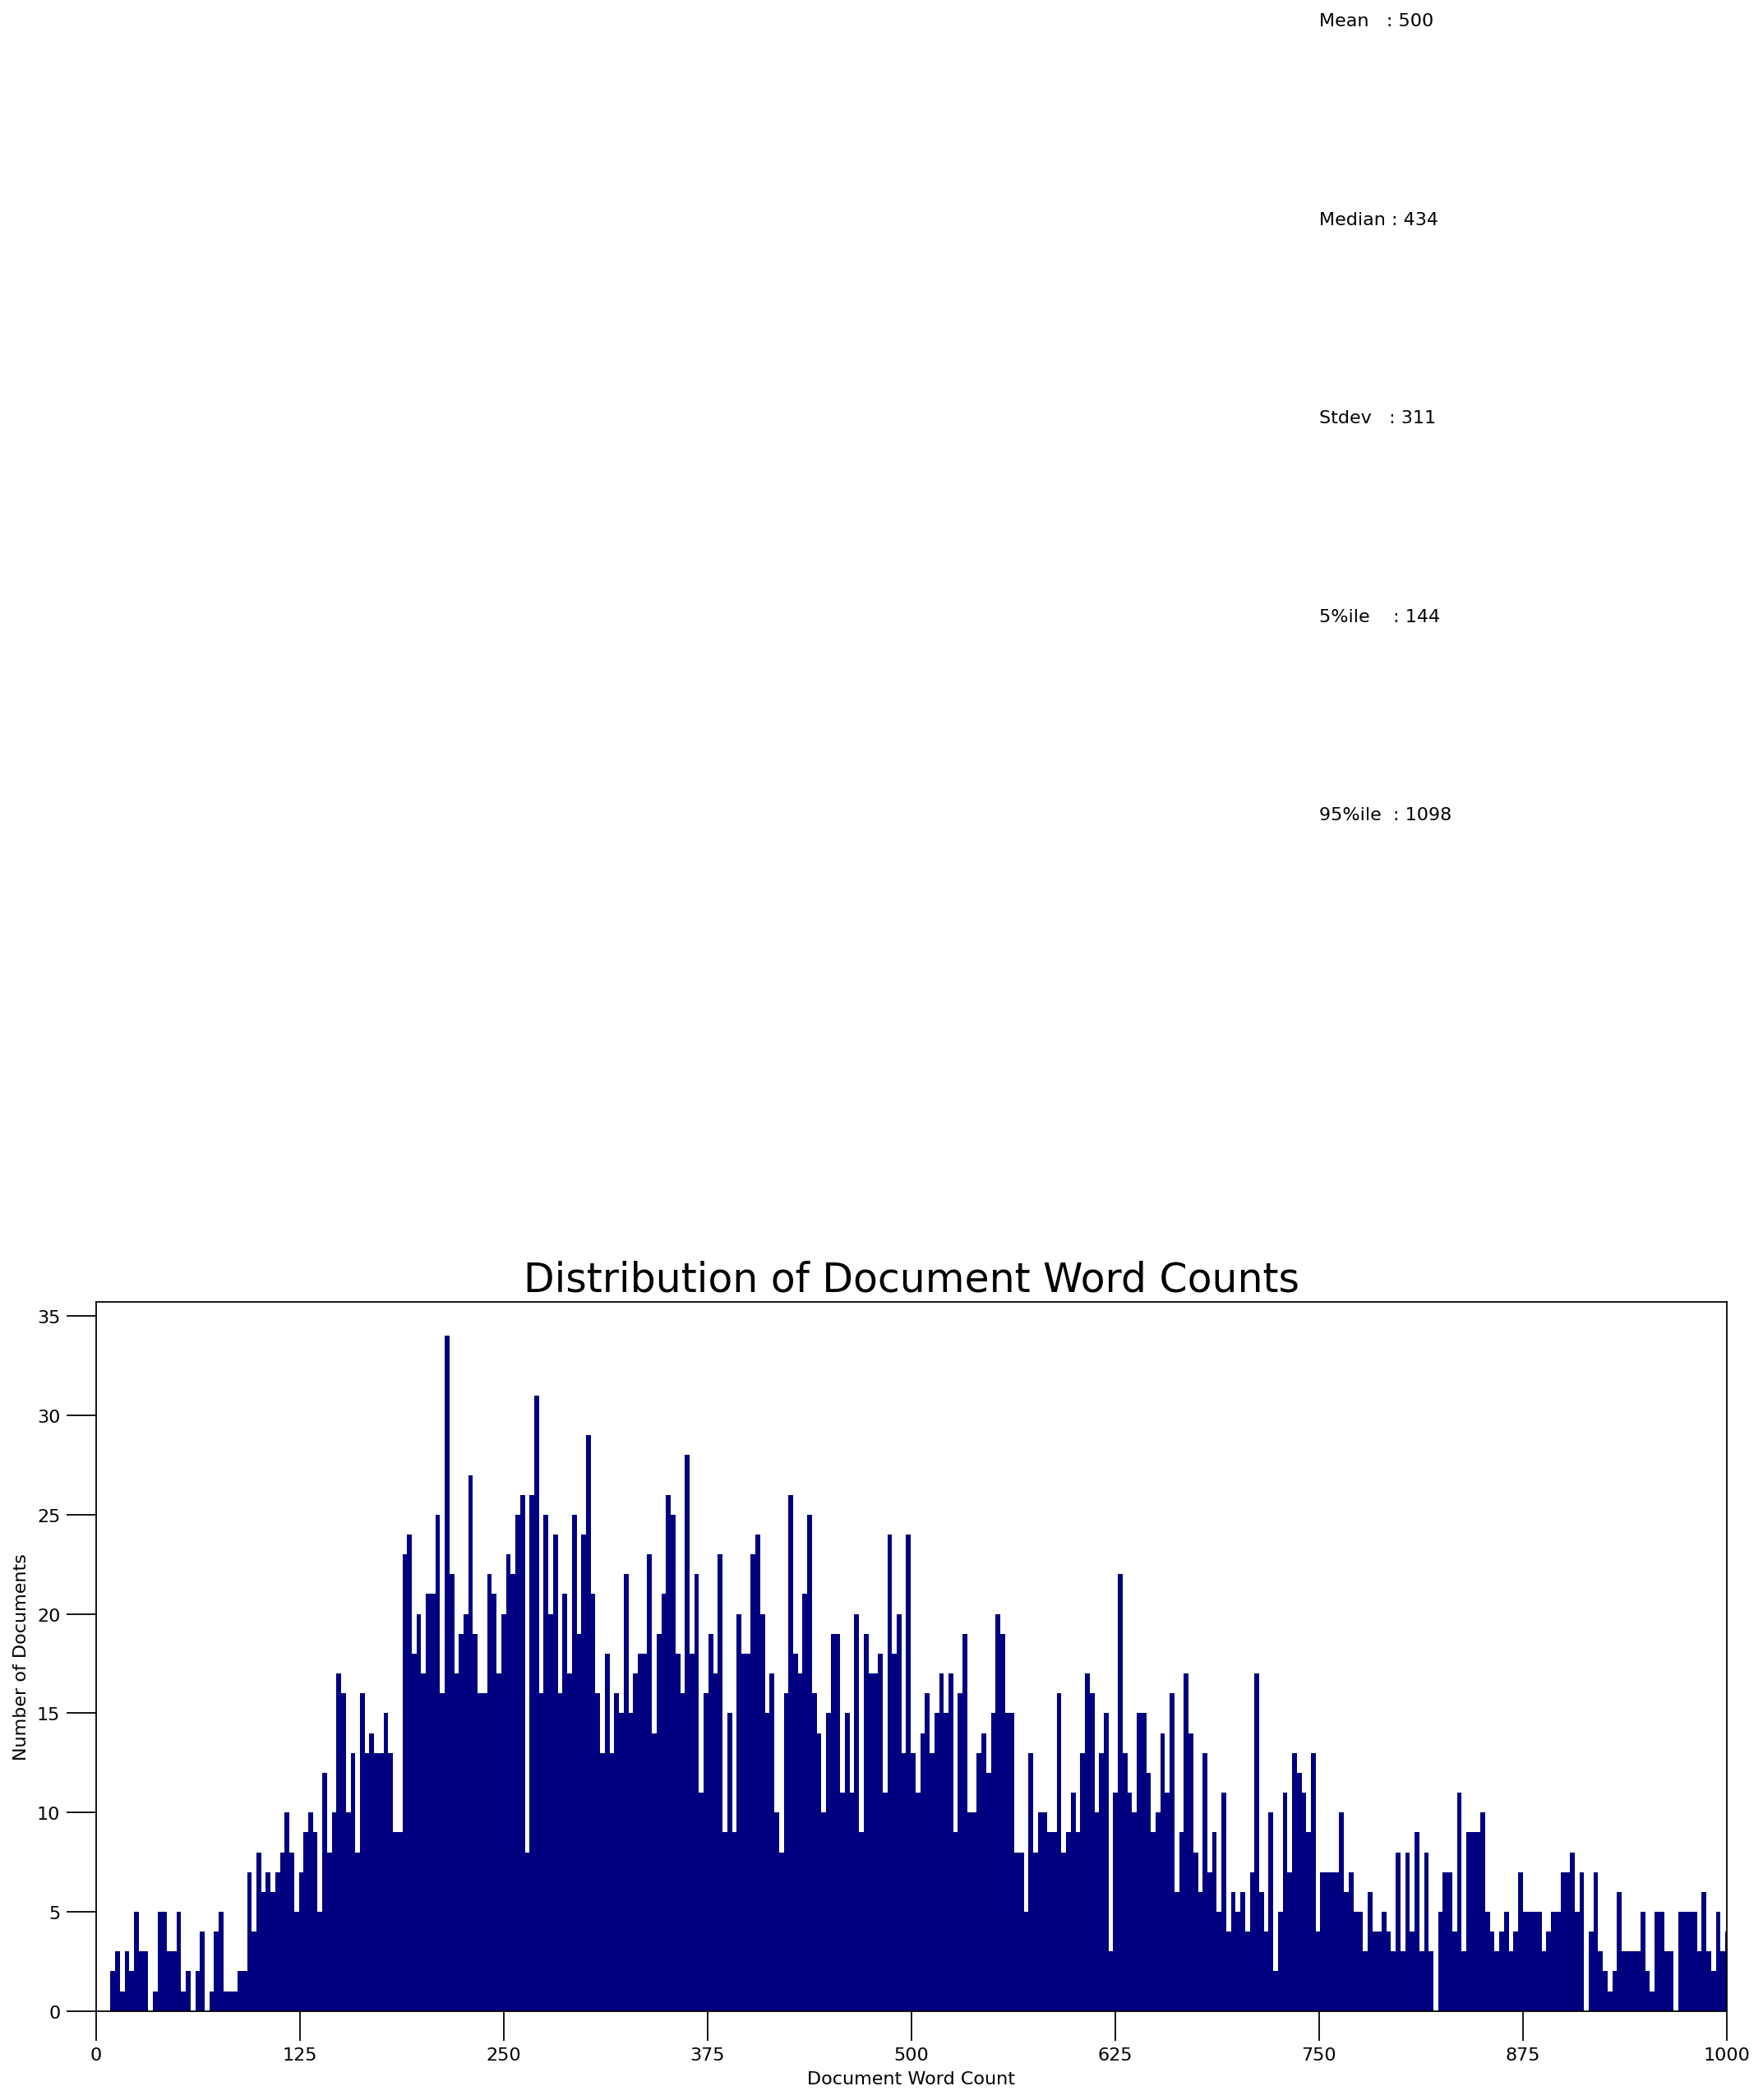

In [52]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "5%ile    : " + str(round(np.quantile(doc_lens, q=0.05))))
plt.text(750,  60, "95%ile  : " + str(round(np.quantile(doc_lens, q=0.95))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

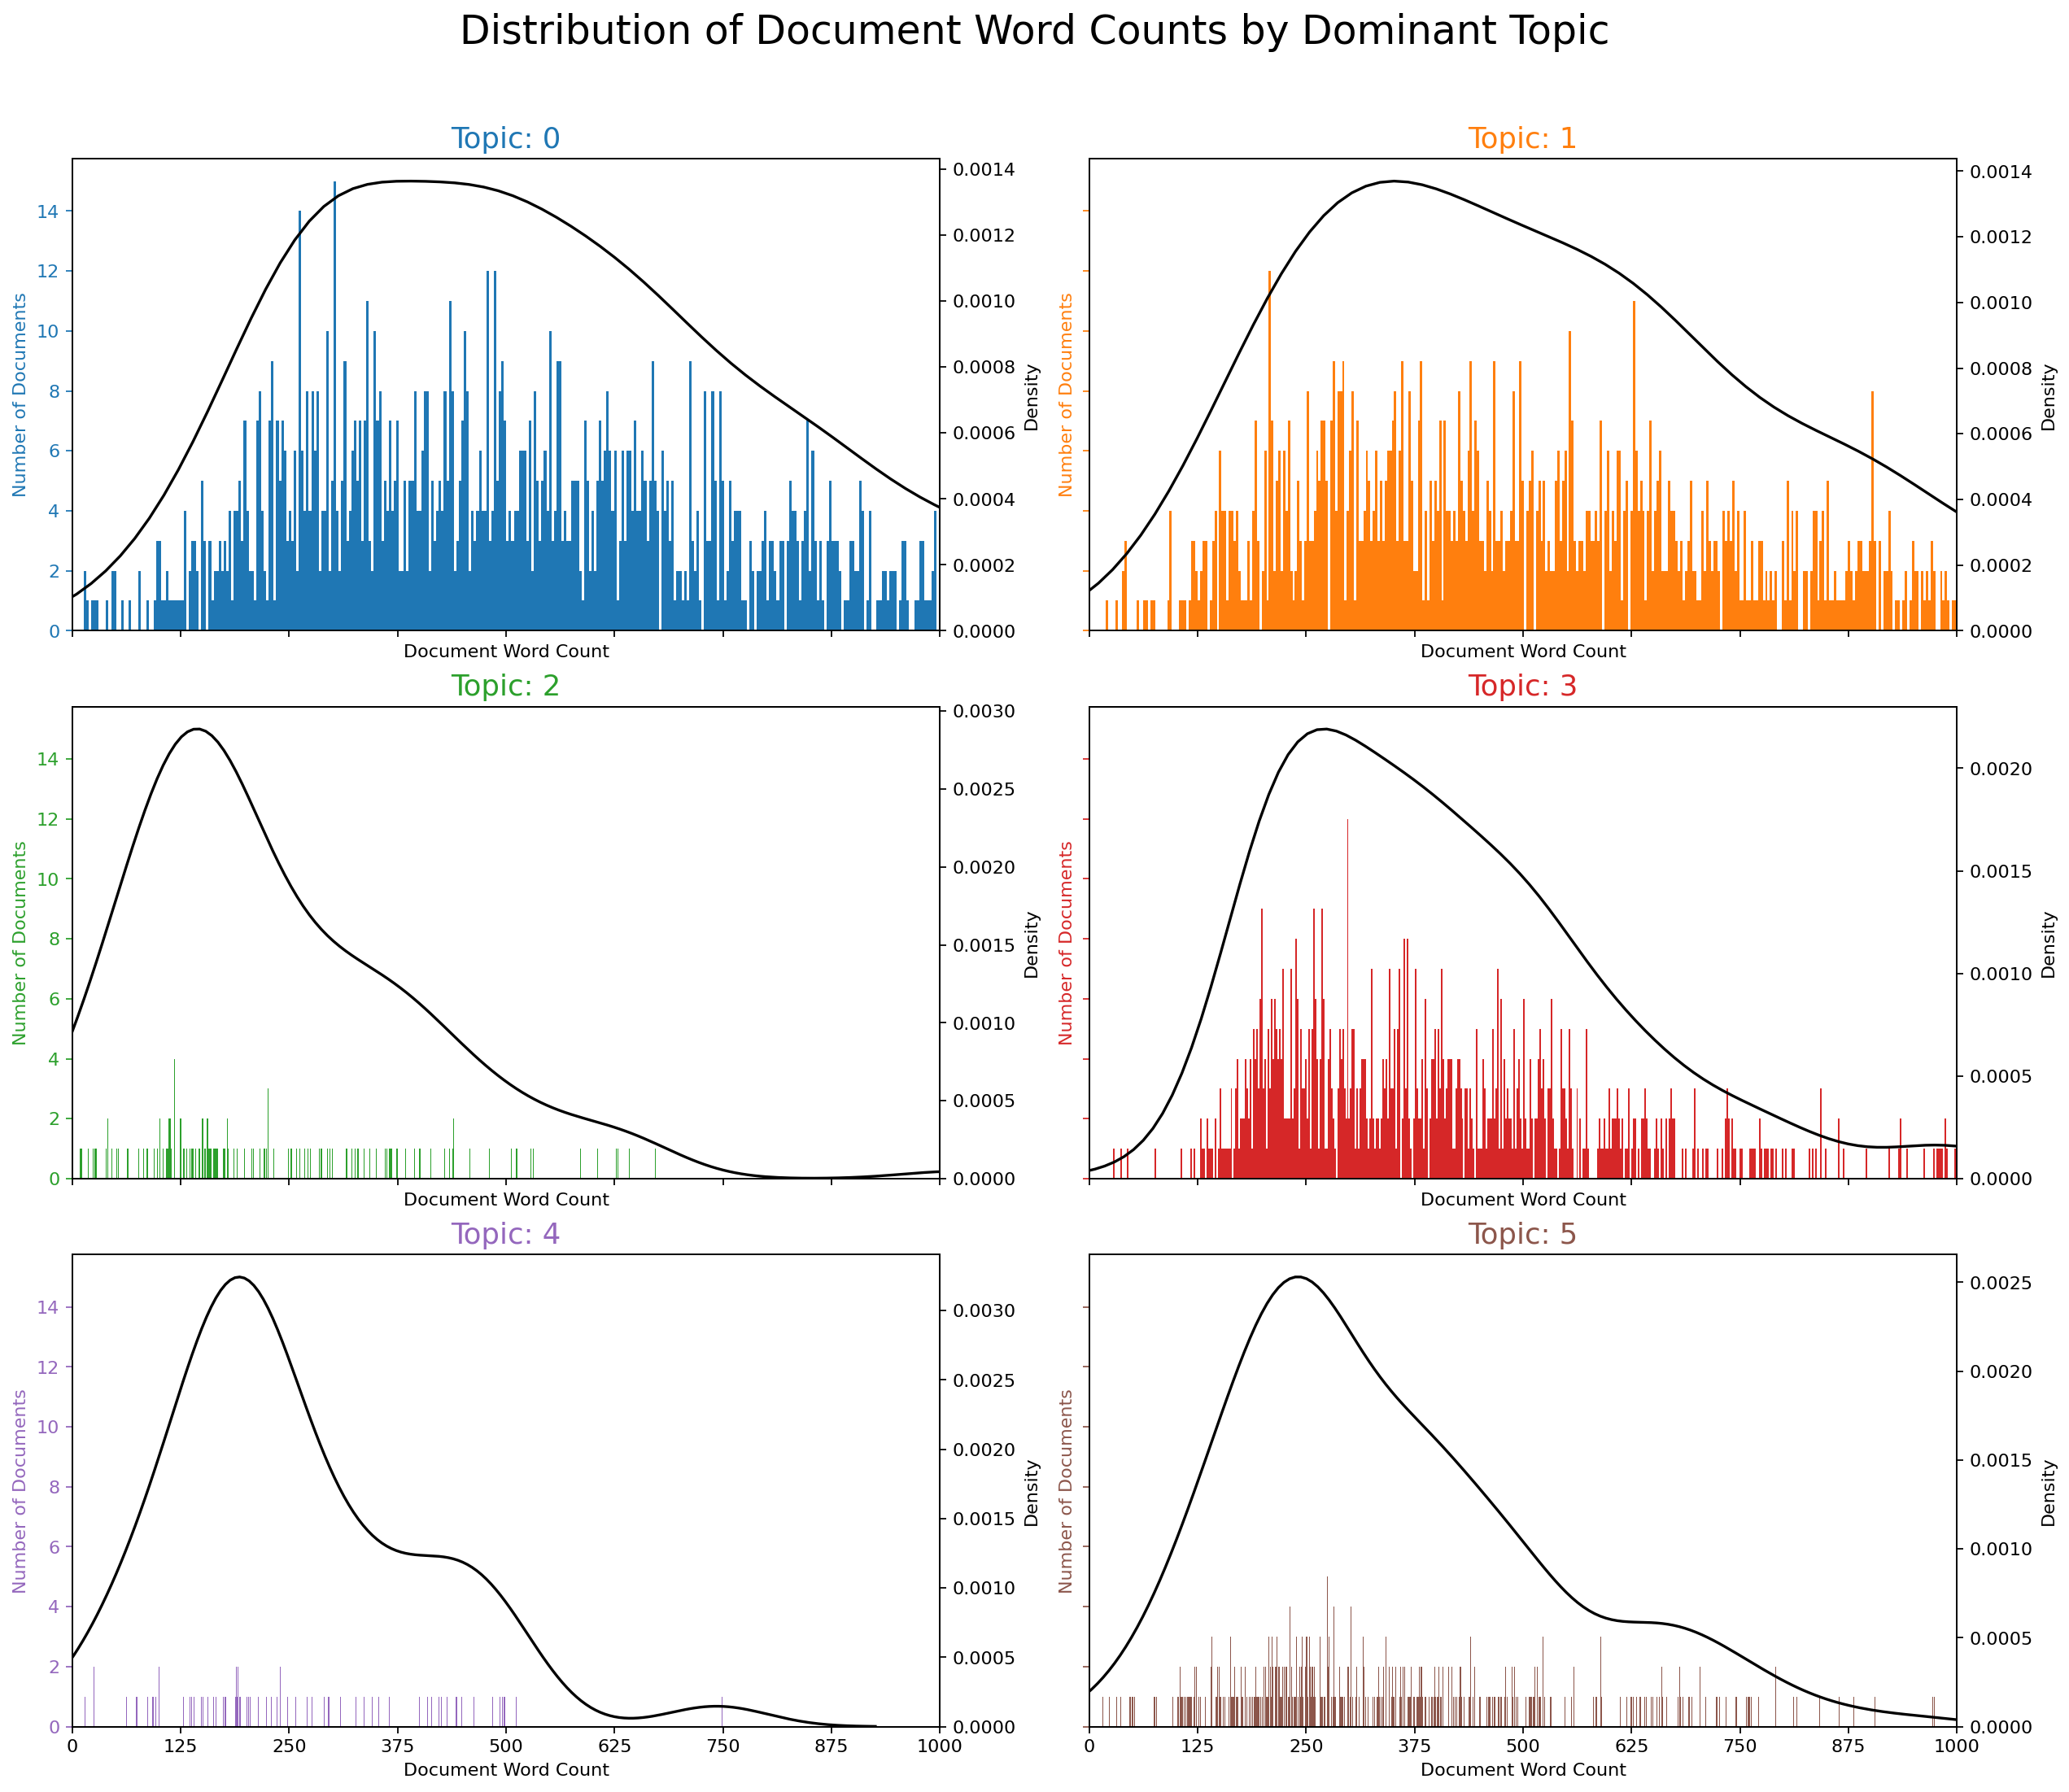

In [53]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

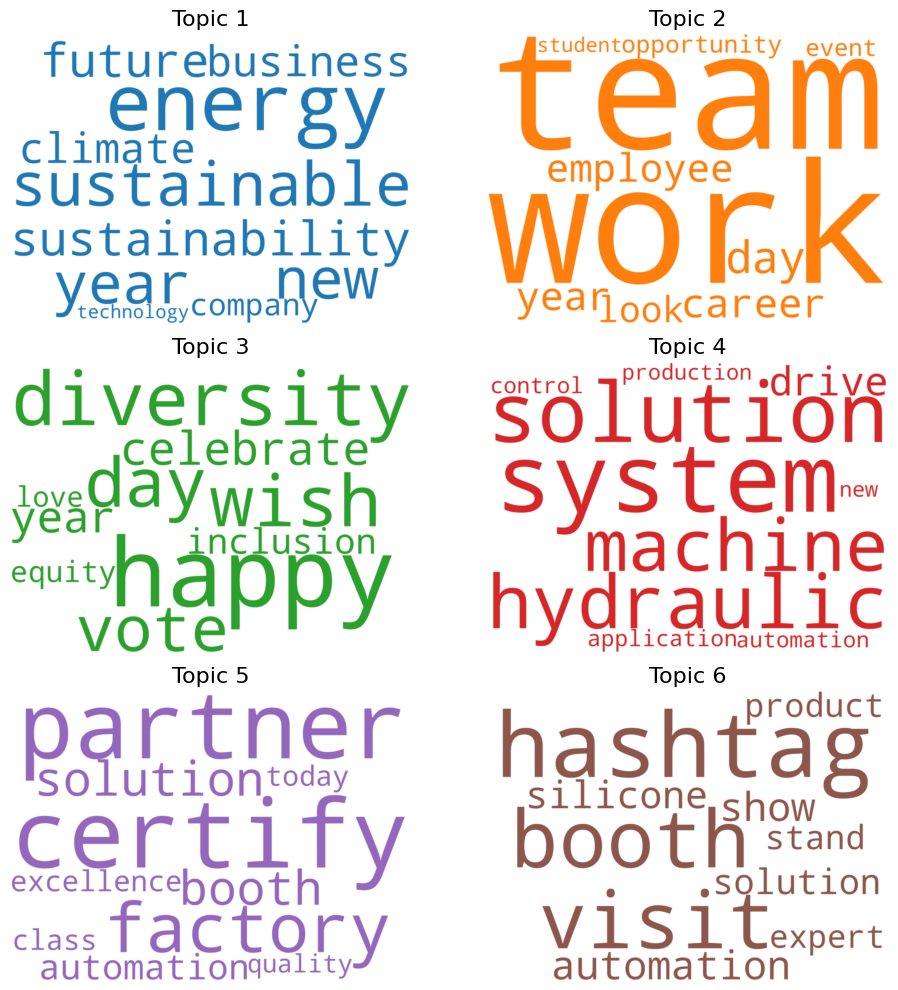

In [54]:
# 1. Wordcloud of Top N words in each topic
num_words = 10  # You can adjust the number of top words
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords='english',
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=num_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


# Assuming you have a trained scikit-learn LDA model 'lda_model' and a vectorizer 'vectorizer'

# Get the top words for each topic from the LDA model
topics = best_lda_model.components_

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(zip(vec_tfidf.get_feature_names_out(), topics[i]))
    top_words = dict(sorted(topic_words.items(), key=lambda x: x[1], reverse=True)[:num_words])
    cloud.generate_from_frequencies(top_words)
    plt.imshow(cloud, interpolation='bilinear')
    plt.title('Topic ' + str(i + 1), size=16)
    plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

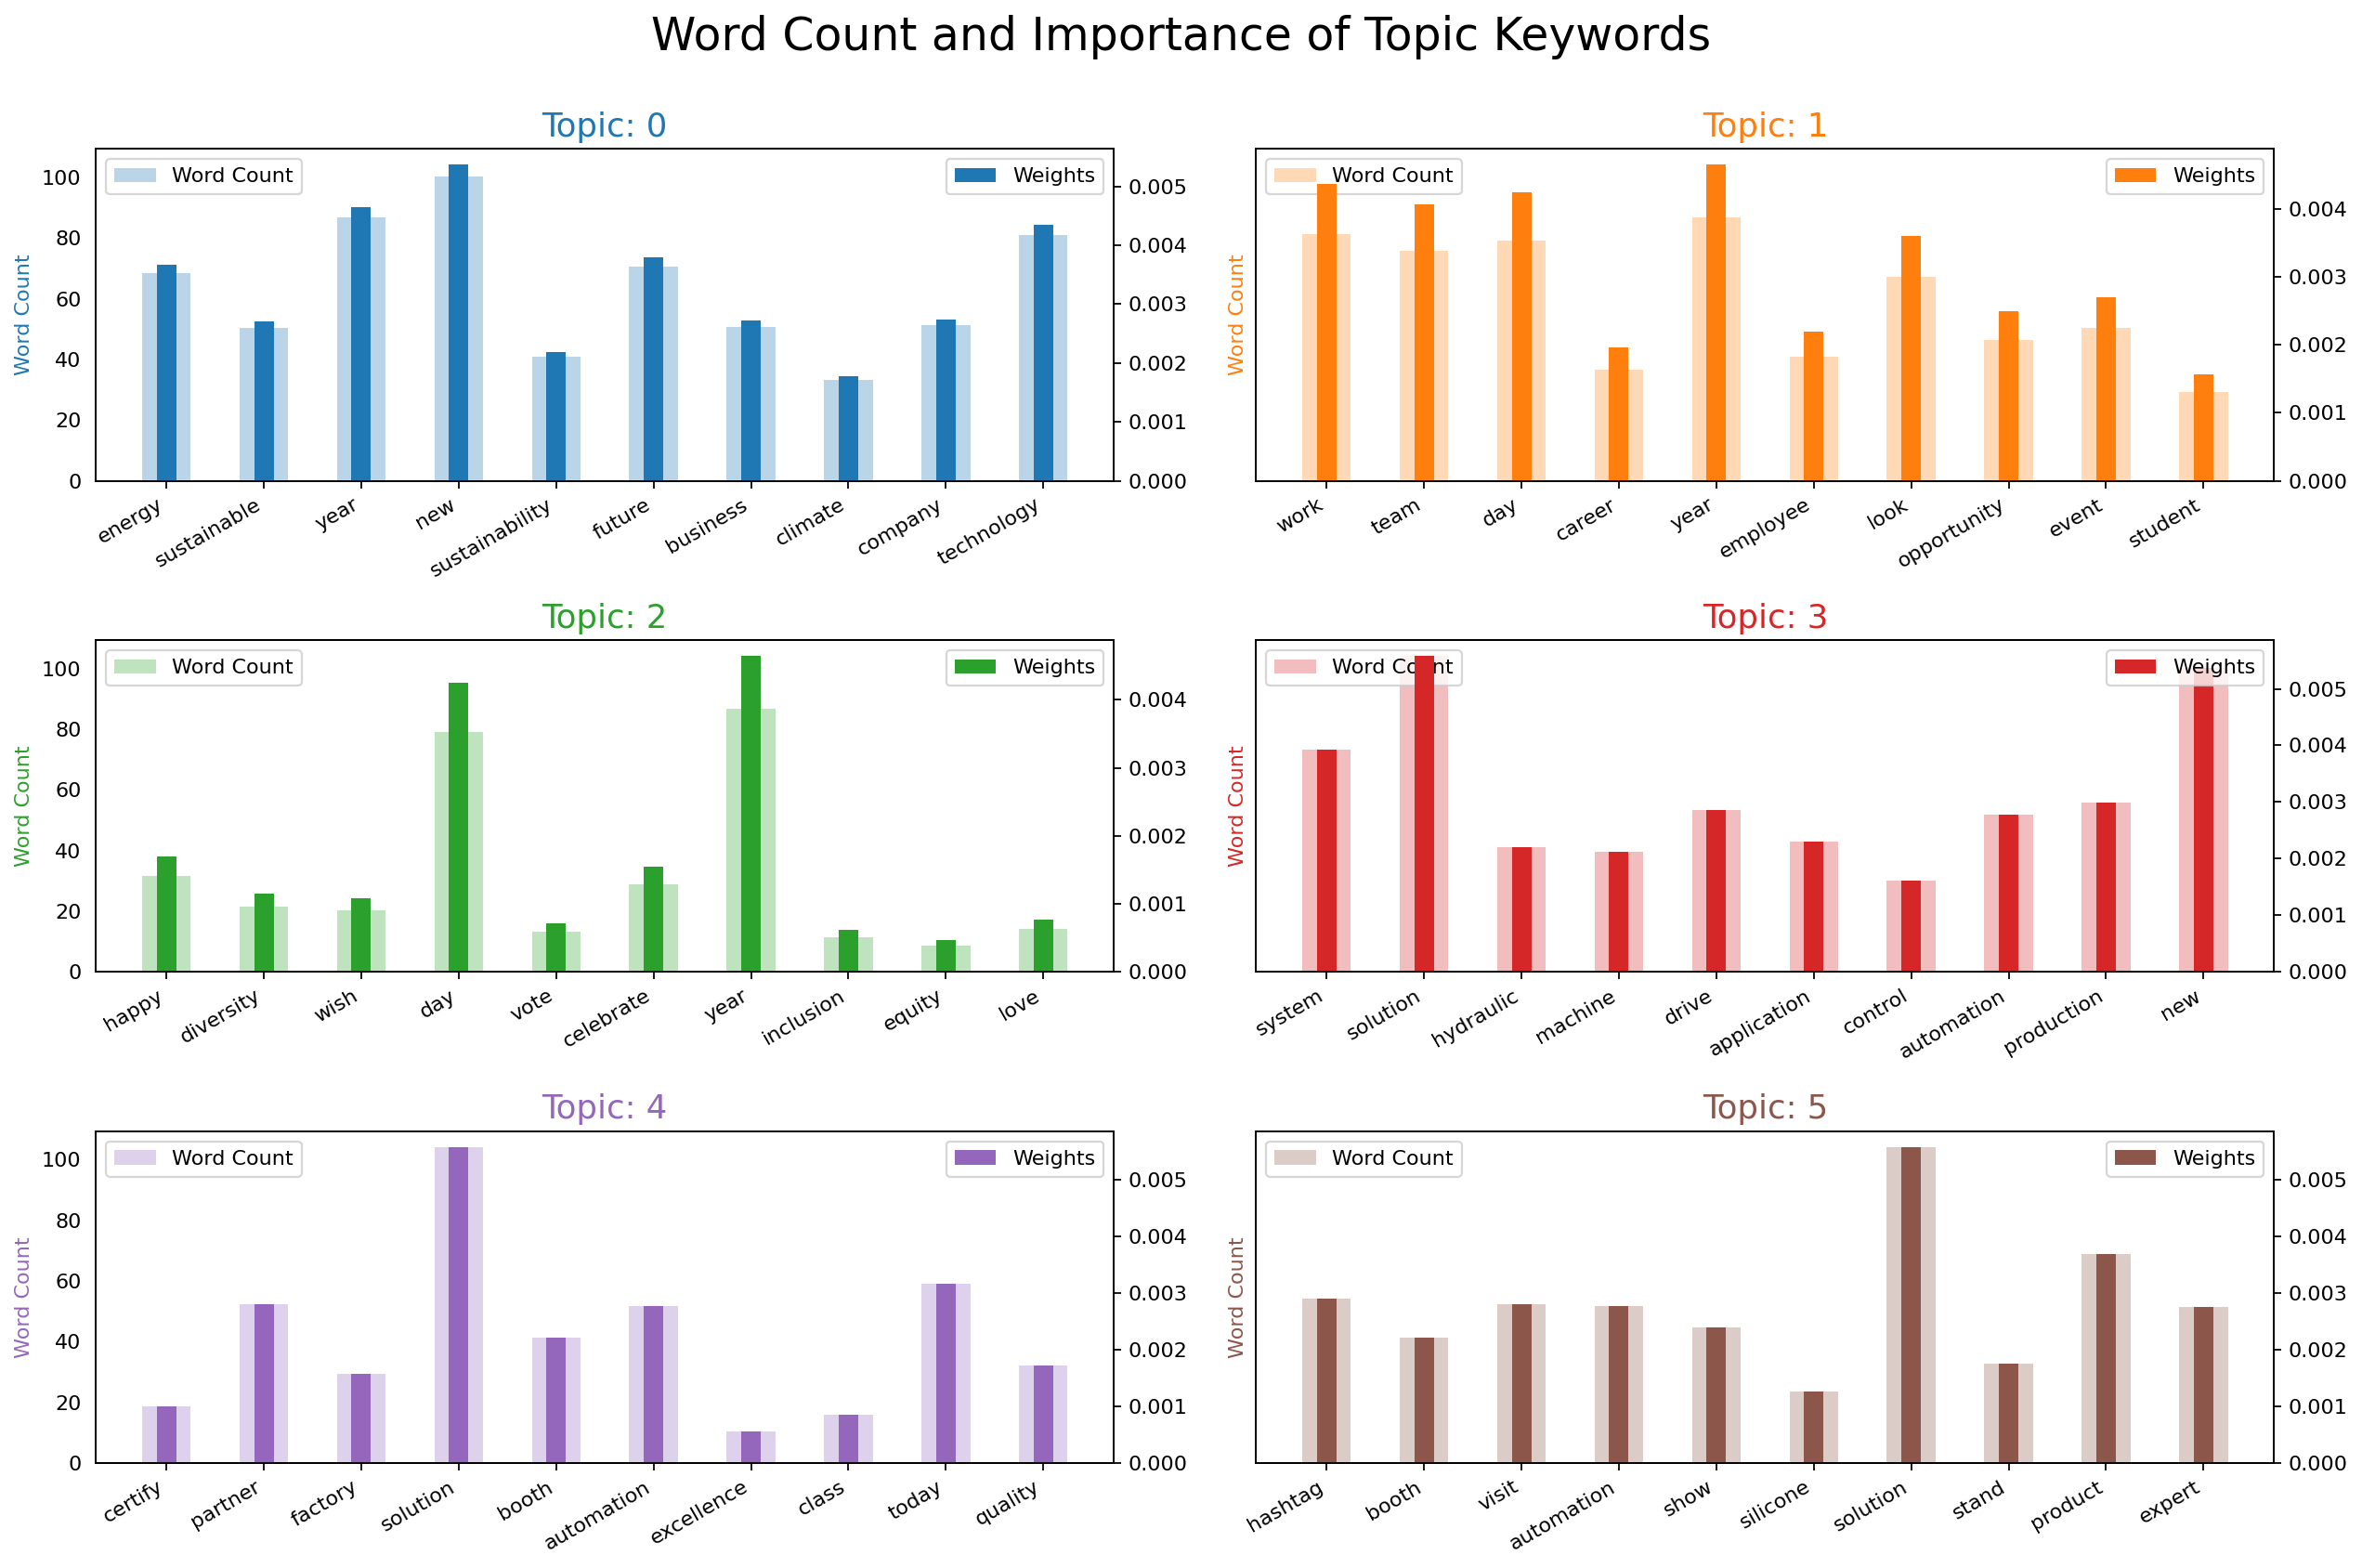

In [55]:
# Get the topics and their top words from the LDA model
num_topics = best_lda_model.n_components
topics = best_lda_model.components_

# Flatten the list of documents and count word occurrences
term_frequencies = X_tfidf.sum(axis=0).A1

# Get the feature names (vocabulary)
vocab = vec_tfidf.get_feature_names_out()

# Create a dictionary to map terms to their frequencies
word_counts = dict(zip(vocab, term_frequencies))

# Initialize a list to store data
out = []

# Iterate through topics and their top words
for i, topic in enumerate(topics):
    top_words = [vec_tfidf.get_feature_names_out()[j] for j in topic.argsort()[-10:][::-1]]  # Adjust the number of top words as needed
    for word in top_words:
        # Get the word count
        word_count = word_counts[word]
        
        # Calculate word importance as word count divided by the total word count
        word_importance = word_count / term_frequencies.sum()
        
        out.append([word, i, word_count, word_importance])

# Create a DataFrame from the collected data
dfK = pd.DataFrame(out, columns=['word', 'topic_id', 'word_count', 'importance'])

max_word_count = dfK['word_count'].max()
max_word_importance = dfK['importance'].max()

fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=dfK.loc[dfK.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=dfK.loc[dfK.topic_id == i, :], color=cols[i], width=0.2, label='Weights')

    # Check if the maximum word count is very small or zero
    if max_word_count < 1e-5:
        y_axis_limit = 0.1  # Set a small non-zero value for the y-axis limit
    else:
        y_axis_limit = max_word_count * 1.2
        
    # if max_word_importance < 1e-5:
    #     y_twin_axis_limit = 0.001
    # else:
    #     y_twin_axis_limit = max_word_importance * 1.2

    #ax.set_ylim(0, y_axis_limit)
    #ax_twin.set_ylim(0, y_twin_axis_limit)

    # Set x-axis tick locations and labels
    x_labels = dfK.loc[dfK.topic_id == i, 'word']
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=30, horizontalalignment='right')

    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)

    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

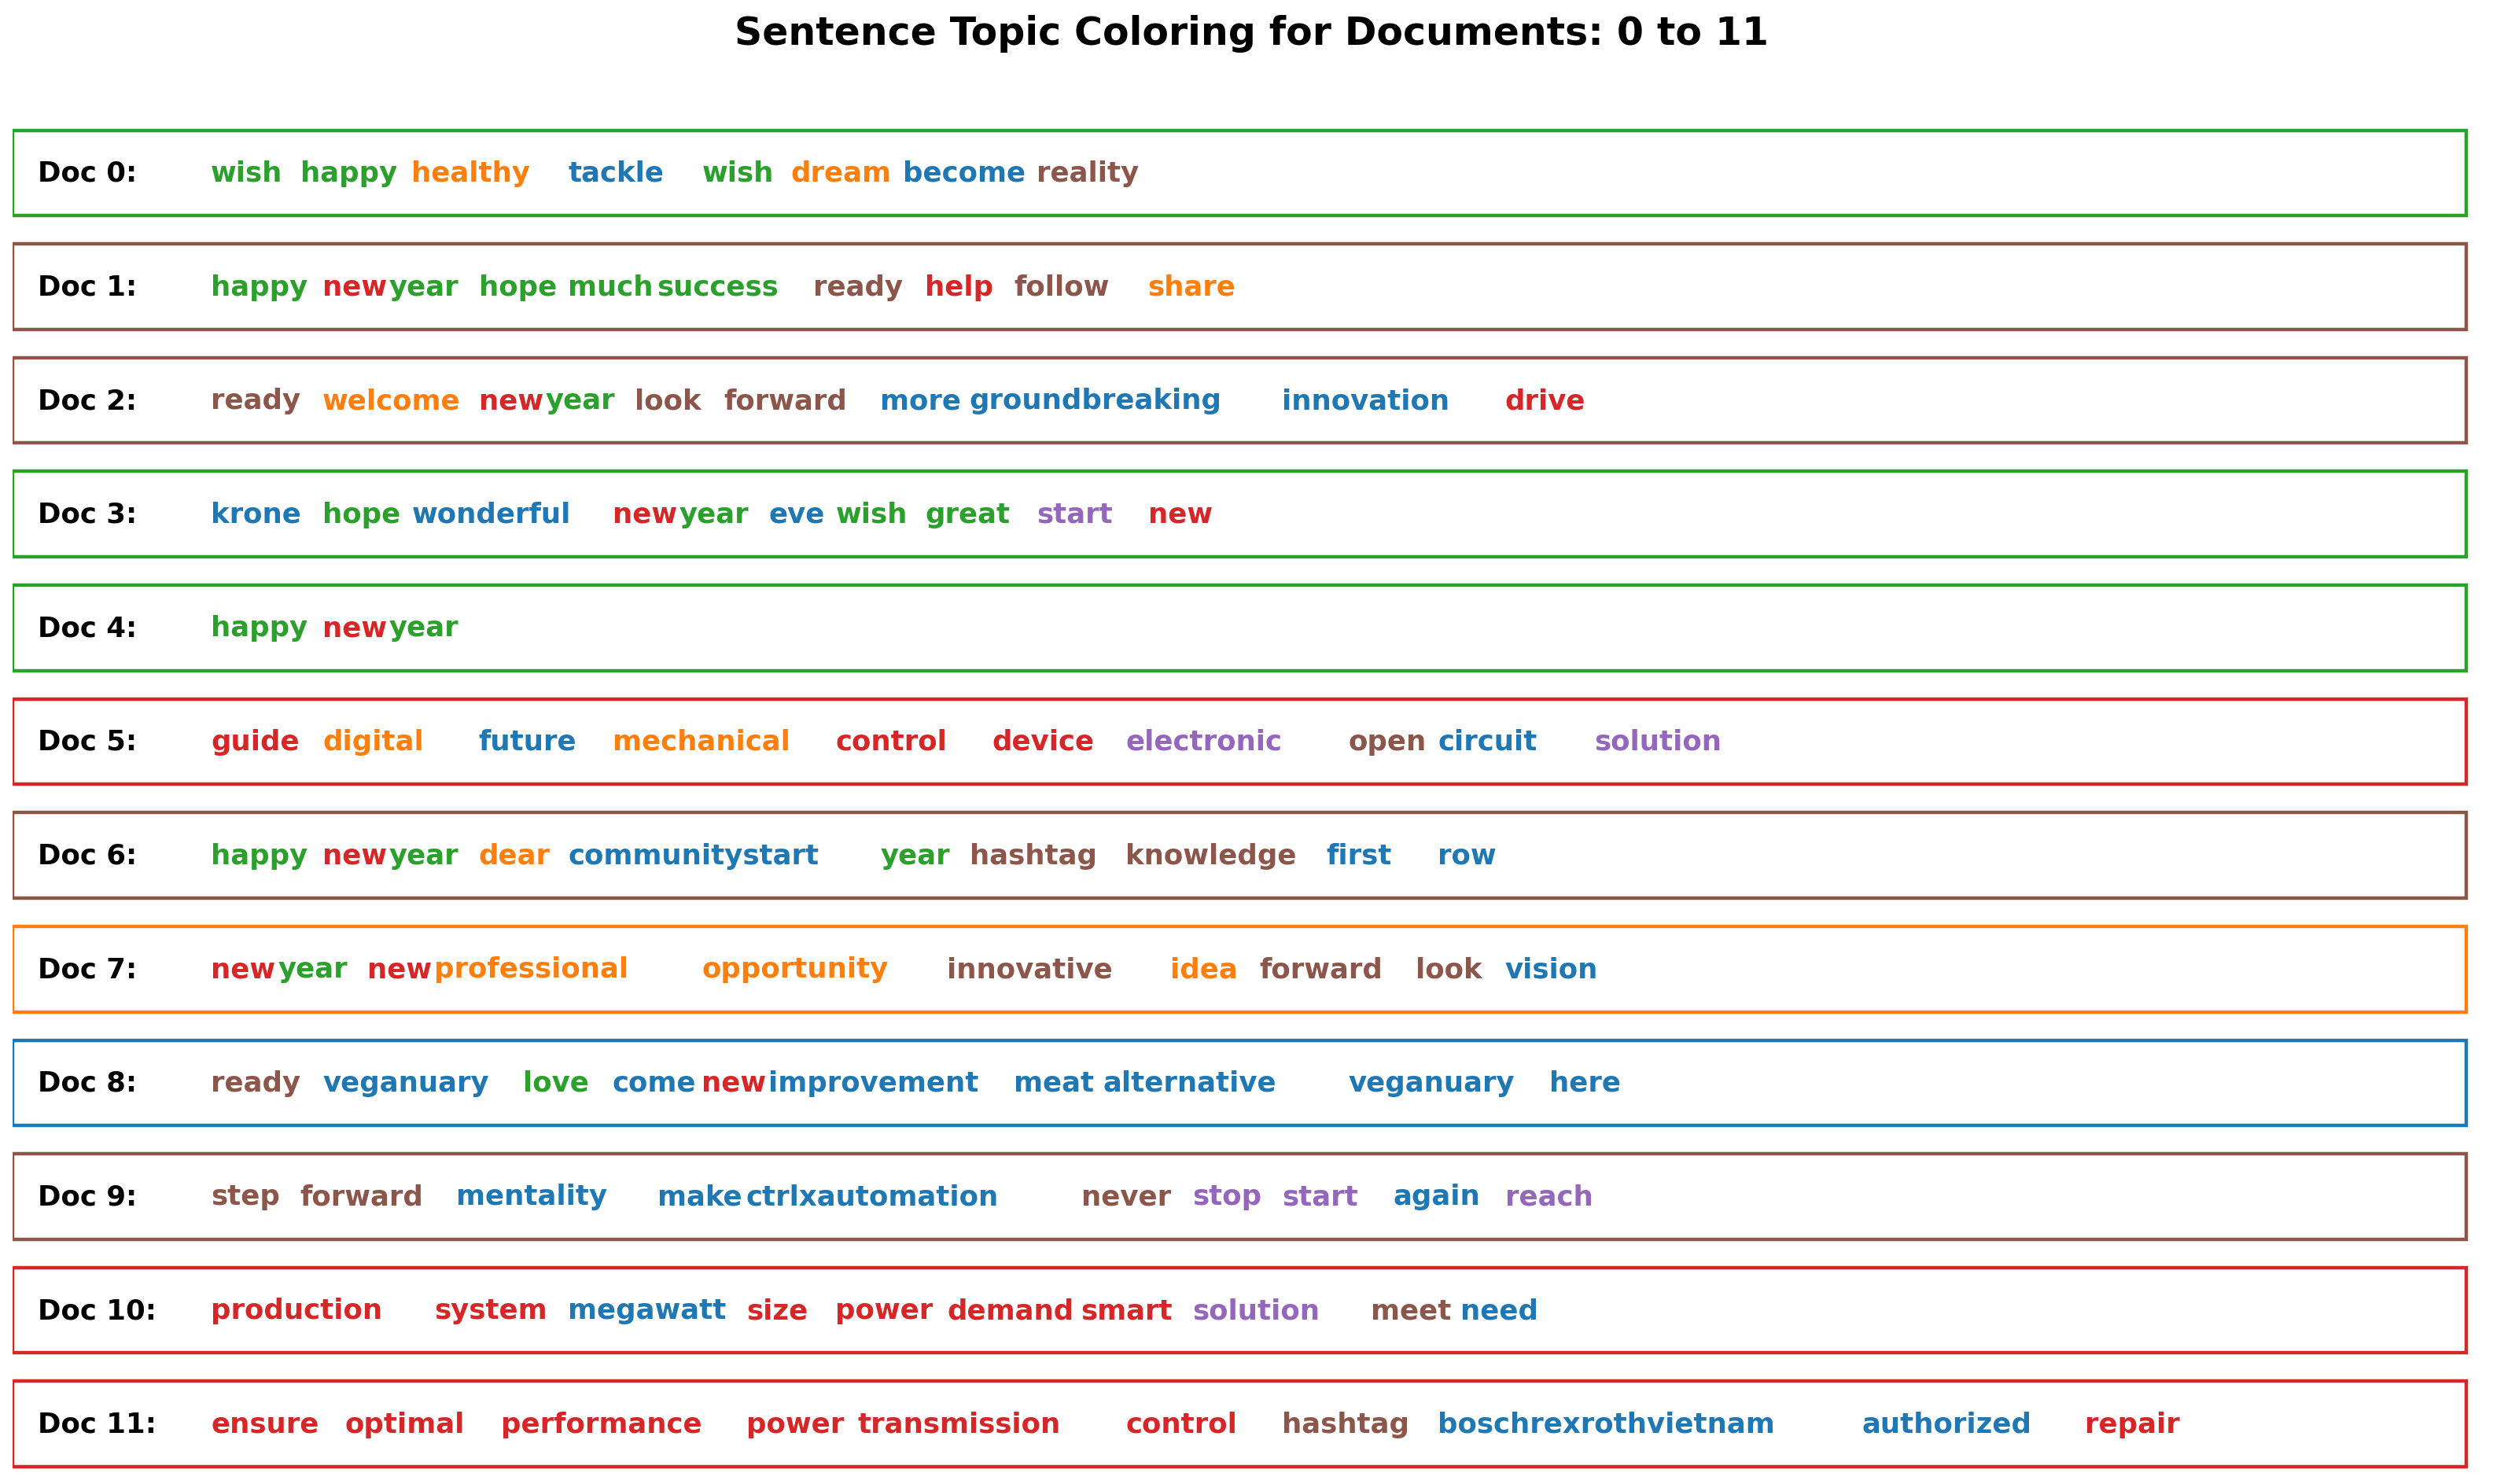

In [56]:
from matplotlib.colors import to_rgba

# Assuming you have a trained scikit-learn LDA model 'lda_model' and a CountVectorizer 'vectorizer'
# You should have 'documents' ready

topic_assignments = best_lda_model.transform(vec_tfidf.transform(data_lemmatized))

# Set the start and end indices for the sentences you want to visualize
start = 0
end = 13

# Get the subset of topic assignments for the selected sentences
topic_assignments_subset = topic_assignments[start:end]

mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)
axes[0].axis('off')

for i, ax in enumerate(axes):
    if i > 0:
        doc_topic_probs = topic_assignments_subset[i - 1]

        # Find the dominant topic for the current document
        dominant_topic = np.argmax(doc_topic_probs)
        max_topic_prob = doc_topic_probs[dominant_topic]

        ax.text(0.01, 0.5, "Doc " + str(i - 1) + ": ", verticalalignment='center',
                fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

        # Draw Rectangle
        ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                               color=mycolors[dominant_topic], linewidth=2))
        
        ax.axis('off')

        # Process each word in the document, limited to the first 10 words
        words = data_lemmatized[i - 1].split()[:10]
        word_x_pos = 0.08

        for word in words:
            # Determine the topic associated with the word
            word_topic = np.argmax(best_lda_model.transform(vec_tfidf.transform([word])))

            # Color the word with the topic's color
            ax.text(
                word_x_pos, 
                0.5, 
                word, 
                fontsize=16,
                horizontalalignment='left',
                verticalalignment='center',
                color=mycolors[word_topic],
                transform=ax.transAxes, 
                fontweight=700)
            word_x_pos += 0.009 * len(word)

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end - 2), fontsize=22, y=0.95, fontweight=700)
plt.tight_layout()
plt.show()

In [57]:
# Get topic weights
topic_weights = best_lda_model.transform(X_tfidf)

# Dominant topic number in each document
topic_num = np.argmax(topic_weights, axis=1)

# t-SNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(topic_weights)

# Plot the Topic Clusters using Matplotlib
n_topics = best_lda_model.n_components
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

# Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4107 samples in 0.003s...
[t-SNE] Computed neighbors for 4107 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4107
[t-SNE] Computed conditional probabilities for sample 2000 / 4107
[t-SNE] Computed conditional probabilities for sample 3000 / 4107
[t-SNE] Computed conditional probabilities for sample 4000 / 4107
[t-SNE] Computed conditional probabilities for sample 4107 / 4107
[t-SNE] Mean sigma: 0.002193
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.875778
[t-SNE] KL divergence after 1000 iterations: 0.368693


Loading BokehJS ...